<a href="https://colab.research.google.com/github/BadAsiv/Homework/blob/main/XJTU/AdvAI/DLG_minist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 在mnist数据集上验证效果

In [1]:
import torch
print("PyTorch版本:", torch.__version__)
print("CUDA是否可用:", torch.cuda.is_available())
print("CUDA版本:", torch.version.cuda)
print("GPU名称:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch版本: 2.5.1+cu121
CUDA是否可用: True
CUDA版本: 12.1
GPU名称: Tesla T4


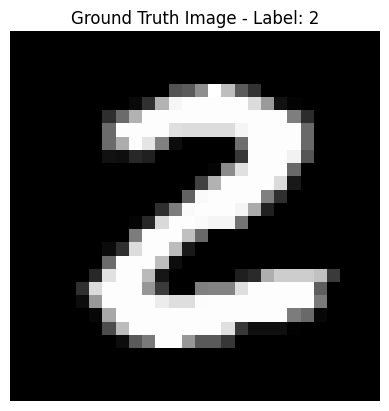

Iteration 0, Loss: 2.324538469314575
Iteration 5, Loss: 2.3222522735595703
Iteration 10, Loss: 2.322619915008545
Iteration 15, Loss: 2.3222155570983887
Iteration 20, Loss: 2.3222954273223877
Iteration 25, Loss: 2.32232403755188
Iteration 30, Loss: 2.3224058151245117
Iteration 35, Loss: 2.3227343559265137
Iteration 40, Loss: 2.3223607540130615
Iteration 45, Loss: 2.322180986404419


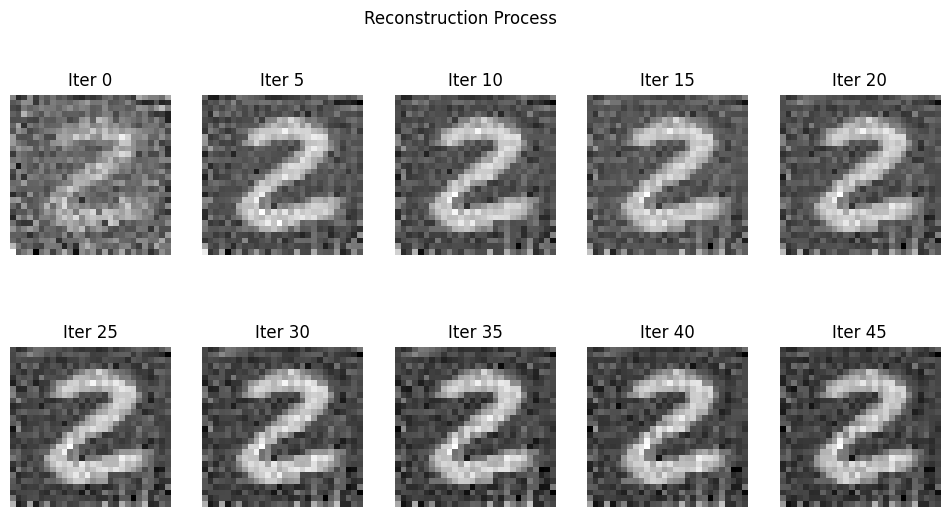

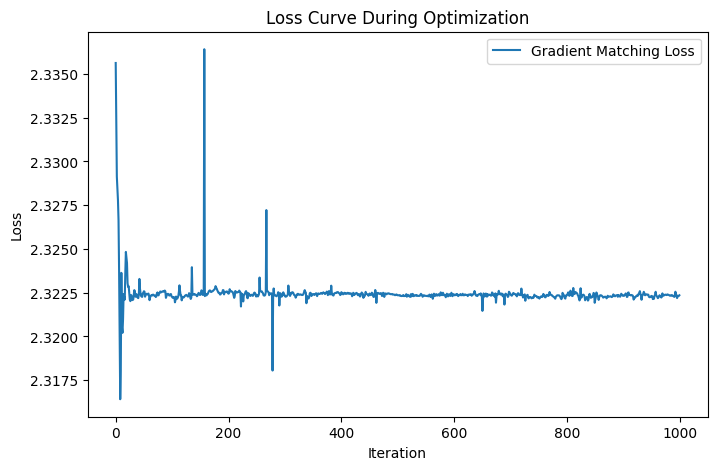

Final Dummy Label:  2


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# =========================
# 1. 数据准备：加载 MNIST 数据集
# =========================
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为 [0, 1] 的张量
])

# 下载 MNIST 数据集
mnist_train = datasets.MNIST(root="~/.torch", train=True, transform=transform, download=True)
#本地下载加载MNIST数据集
# mnist_train = datasets.MNIST(root="./torch", train=True, transform=transform, download=False)


# 选取一张图像作为 Ground Truth
img_index = 25  # 选择第 25 张图像
gt_data, gt_label = mnist_train[img_index]
gt_data = gt_data.unsqueeze(0).to("cpu")  # 增加 batch 维度
gt_label = torch.tensor([gt_label]).to("cpu")

# 将标签转换为 One-Hot 编码
def label_to_onehot(target, num_classes=10):
    onehot = torch.zeros(target.size(0), num_classes)
    onehot.scatter_(1, target.unsqueeze(1), 1)
    return onehot

gt_onehot_label = label_to_onehot(gt_label)

# 显示真实图像与标签
plt.imshow(gt_data[0][0].cpu().detach(), cmap="gray")
plt.title(f"Ground Truth Image - Label: {gt_label.item()}")
plt.axis("off")
plt.show()

# =========================
# 2. 定义简单的 LeNet 网络
# =========================
class SimpleLeNet(nn.Module):
    def __init__(self):
        super(SimpleLeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net = SimpleLeNet().to("cpu")

# =========================
# 3. 计算真实数据的梯度
# =========================
criterion = nn.CrossEntropyLoss()
output = net(gt_data)
loss = criterion(output, gt_label)
original_dy_dx = torch.autograd.grad(loss, net.parameters())

# =========================
# 4. 生成虚拟数据和标签
# =========================
dummy_data = torch.randn(gt_data.size(), requires_grad=True)
dummy_label = torch.randn(gt_onehot_label.size(), requires_grad=True)

# =========================
# 5. 使用 LBFGS 优化器重建虚拟数据
# =========================
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
history = []
loss_history = []

def closure():
    optimizer.zero_grad()
    pred = net(dummy_data)
    dummy_onehot = F.softmax(dummy_label, dim=-1)
    dummy_loss = -torch.sum(dummy_onehot * F.log_softmax(pred, dim=-1))
    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

    grad_diff = 0
    for gx, gy in zip(dummy_dy_dx, original_dy_dx):
        grad_diff += ((gx - gy) ** 2).sum()
    grad_diff.backward()
    loss_history.append(dummy_loss.item())
    return grad_diff

# 执行优化过程
for iters in range(50):  # 减少迭代次数
    optimizer.step(closure)
    if iters % 5 == 0:  # 每 5 次保存图像
        print(f"Iteration {iters}, Loss: {loss_history[-1]}")
        history.append(dummy_data.clone().detach())

# =========================
# 6. 可视化重建过程
# =========================
plt.figure(figsize=(12, 6))
for i in range(len(history)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(history[i][0][0].cpu().detach(), cmap="gray")
    plt.title(f"Iter {i * 5}")
    plt.axis("off")
plt.suptitle("Reconstruction Process")
plt.show()

# 绘制损失变化曲线
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Gradient Matching Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve During Optimization")
plt.legend()
plt.show()

# 输出最终的虚拟标签
print("Final Dummy Label: ", torch.argmax(dummy_label, dim=-1).item())


**方案存在下面的问题**

---

### **1. 梯度匹配问题**
- 在 `closure()` 中，损失是基于 **虚拟数据的梯度与真实数据梯度的差异** 来计算的。但这种梯度匹配方法依赖于优化器对参数的敏感性。
- **现象**：如果梯度变化不足或没有正确地引导虚拟数据的更新，优化过程会卡在某个点，导致损失无法进一步下降。

---

### **2. 虚拟标签的优化问题**
- 你的 `dummy_label` 是随机初始化的，但通过 `F.softmax` 转换为概率分布后，梯度可能会太小，导致优化器无法有效地更新虚拟标签。
- **现象**：虚拟标签 (`dummy_label`) 在训练过程中没有显著变化，虚拟数据因此无法正确调整。

---

### **3. 优化器 (LBFGS) 的局限性**
- **LBFGS** 优化器适合小规模参数优化，但对随机初始化的 `dummy_data` 和 `dummy_label`，它可能过早收敛到次优解。
- **现象**：优化过程陷入局部最优点，损失卡住无法进一步下降。

---